# ECOv003 JET Accuracy Analysis with ECOv002 Cal-Val

This notebook performs a sensitivity analysis of the JET ensemble using ECOSTRESS Collection 2 Cal-Val data. 

## Import Required Libraries and Functions

This cell imports all necessary libraries and functions for data processing, model execution, statistical analysis, and plotting. It includes custom modules for the JET ensemble, sensitivity analysis, and net radiation calculations, as well as standard scientific Python libraries.

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
from typing import Callable
from os import makedirs
from os.path import join
import numpy as np
import pandas as pd
from verma_net_radiation import verma_net_radiation_table
from ECOv003_L3T_L4T_JET import process_JET_table, load_ECOv002_calval_JET_inputs
from monte_carlo_sensitivity import perturbed_run, sensitivity_analysis, divide_absolute_by_unperturbed, sensitivity_magnitude_barchart
import matplotlib.pyplot as plt
from scipy.stats import mstats
import seaborn as sns
from matplotlib.ticker import FuncFormatter

## Configuration Options

In [3]:
input_variables = [
    "ST_C",
    "NDVI",
    "albedo",
    "Ta_C",
    "RH",
    "AOT",
    "COT",
    "vapor_gccm",
    "ozone_cm",
    "elevation_m",
    "canopy_height_meters"
]

output_variables = [
    "Rn_Wm2",
    "ET_daylight_kg",
    "GPP_inst_g_m2_s"
]

# Per-variable physical bounds to keep perturbations realistic
input_min = {
    "ST_C": 0.0,
    "NDVI": 0.05,
    "albedo": 0.0,
    "Ta_C": 0.0,
    "RH": 0.0,
    "AOT": 0.0,
    "COT": 0.0,
    "vapor_gccm": 0.0,
    "ozone_cm": 0.0,
    "elevation_m": 0.0,
    "canopy_height_meters": 0.0,
}

input_max = {
    "ST_C": 50.0,
    "NDVI": 1,
    "albedo": 1,
}

## Define Processing Function for Model Table

In [4]:
def JET_with_verma_Rn(*args, **kwargs):
    return process_JET_table(*args, Rn_model_name="verma", **kwargs)

def JET_with_BESS_Rn(*args, **kwargs):
    return process_JET_table(*args, Rn_model_name="BESS", **kwargs)

## Load and Filter Input Data

This cell loads the ECOSTRESS Cal-Val input data using a custom loader function and filters out surface temperatures greater than 50 Celsius and NDVI values less than 0.05. The resulting DataFrame is displayed for inspection.

In [5]:
input_df = load_ECOv002_calval_JET_inputs()

# Apply lower and upper bounds from configuration dictionaries
mask = pd.Series(True, index=input_df.index)
for var, min_val in input_min.items():
    if var in input_df.columns:
        mask &= input_df[var] >= min_val
for var, max_val in input_max.items():
    if var in input_df.columns:
        mask &= input_df[var] <= max_val

input_df = input_df[mask]
input_df = input_df.dropna()
input_df

,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,CL,Tmin_open,Tmin_closed,VPD_open,VPD_closed,Tmin_C,Topt_C,fAPARmax,field_capacity,wilting_point
15,15,US-xAB,ENF,Csb,141.635670,168.24043,402.81810,159.71700,139.016083,107.183200,...,0.0032,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16
17,17,US-xAB,ENF,Csb,1.881266,163.94730,301.40400,179.13661,131.273636,106.525215,...,0.0032,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16
18,18,US-xAB,ENF,Csb,3.135606,246.87700,614.51480,405.50497,366.056641,222.890230,...,0.0032,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16
19,19,US-xAB,ENF,Csb,311.482820,290.73126,672.27510,478.82382,439.821228,153.787670,...,0.0032,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16
20,20,US-xAB,ENF,Csb,51.920338,95.28810,116.67136,73.20884,232.693512,24.038680,...,0.0032,8.31,-8.0,650.0,3000.0,11.940895,6.69,0.6040,0.33,0.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,992,US-xML,DBF,Dfb,417.831120,706.93066,523.92740,310.69684,356.174072,148.624050,...,0.0065,11.39,-8.0,650.0,3500.0,27.538052,2.66,0.5404,0.34,0.14
994,994,US-xML,DBF,Dfb,161.558200,306.15277,420.44678,206.48576,237.659103,98.727560,...,0.0065,11.39,-8.0,650.0,3500.0,27.538052,2.66,0.5404,0.34,0.14
1001,1001,US-UiB,CRO,Dfa,93.876100,251.38747,238.71077,198.90399,106.316444,67.694800,...,0.0070,12.02,-8.0,650.0,4500.0,9.637029,2.58,0.4060,0.32,0.14
1020,1020,US-ARM,CRO,Cfa,80.255005,0.00000,180.10085,211.28325,164.581390,84.672410,...,0.0070,12.02,-8.0,650.0,4500.0,9.637029,8.48,0.4017,0.29,0.12


## Process Input Data Through Model

This cell applies the processing function to the filtered input data, running it through the model, and displays the resulting DataFrame.

[2026-01-30 09:54:18 INFO] starting JET table processing
[2026-01-30 09:54:18 INFO] started extracting geometry from JET input table
[2026-01-30 09:54:18 INFO] completed extracting geometry from JET input table (0.004 seconds)
[2026-01-30 09:54:18 INFO] started extracting time from JET input table
[2026-01-30 09:54:18 INFO] completed extracting time from JET input table (0.001 seconds)
[2026-01-30 09:54:18 INFO] running Forest Light Environmental Simulator
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[2026-01-30 09:54:18 INFO] completed processing FLiES-ANN in 0.12 seconds
[2026-01-30 09:54:18 INFO] variable PAR_albedo min: 0.007 mean: 0.055 max: 0.193 nan: 0.00% (nan)
[2026-01-30 09:54:18 INFO] variable NIR_albedo min: 0.066 mean: 0.162 max: 0.530 nan: 0.00% (nan)
[2026-01-30 09:54:18 INFO] variable PAR_direct_Wm2 min: 7.148 mean: 269.735 max: 442.463 nan: 0.00% (nan)
[2026-01-30 09:54:18 INFO] variable SWin_FLiES_ANN min: 163.676 mean: 716.916 max: 1095.605 nan: 0.00% (nan)
[2026-01-30 09:5

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')


[2026-01-30 09:54:18 INFO] completed daylight ET upscaling (elapsed: 0.02 seconds)
[2026-01-30 09:54:18 INFO] completed processing BESS-JPL in 0.09 seconds
[2026-01-30 09:54:18 INFO] variable Rn_BESS_Wm2 min: 67.033 mean: 426.438 max: 815.548 nan: 0.00% (nan)
[2026-01-30 09:54:18 INFO] variable Rn_BESS_Wm2 min: 67.033 mean: 426.438 max: 815.548 nan: 0.00% (nan)
[2026-01-30 09:54:18 INFO] variable LE_BESS_Wm2 min: 3.648 mean: 86.108 max: 368.953 nan: 0.00% (nan)
[2026-01-30 09:54:18 INFO] calculating solar day of year
[2026-01-30 09:54:18 INFO] calculating solar hour of day
[2026-01-30 09:54:18 INFO] calculating daylight hours and sunrise hour
[2026-01-30 09:54:18 INFO] variable LE_BESS_Wm2 min: 3.648 mean: 86.108 max: 368.953 nan: 0.00% (nan)
[2026-01-30 09:54:18 INFO] variable GPP_inst_umol_m2_s min: 0.006 mean: 6.632 max: 39.888 nan: 0.00% (nan)
[2026-01-30 09:54:18 INFO] starting Verma net radiation processing
[2026-01-30 09:54:18 INFO] variable SWout_Wm2 min: 9.139 mean: 79.449 max

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones availab

[2026-01-30 09:54:18 INFO] completed daylight ET upscaling (PMJPL)
[2026-01-30 09:54:18 INFO] completed processing PM-JPL in 0.09 seconds
[2026-01-30 09:54:18 INFO] variable LE_PMJPL_Wm2 min: 6.339 mean: 94.697 max: 477.719 nan: 0.00% (nan)
[2026-01-30 09:54:18 INFO] variable ET_daylight_PMJPL_kg min: 0.064 mean: 1.330 max: 6.335 nan: 0.00% (nan)
[2026-01-30 09:54:18 INFO] variable G_PMJPL_Wm2 min: 2.904 mean: 69.742 max: 177.794 nan: 0.00% (nan)
[2026-01-30 09:54:18 INFO] variable ET_daylight_kg min: 0.383 mean: 1.870 max: 5.972 nan: 0.00% (nan)
[2026-01-30 09:54:18 INFO] JET table processing complete (0.457 seconds)
analyzing JET_with_verma_Rn accuracy for LE_BESS_Wm2 compared to insitu_LE_Wm2


/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')


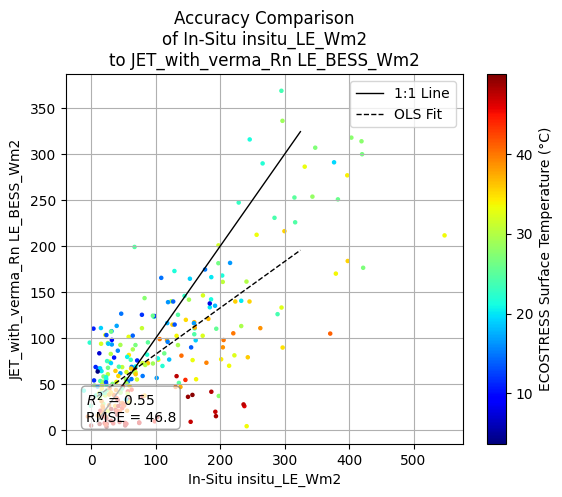

analyzing JET_with_verma_Rn accuracy for LE_STIC_Wm2 compared to insitu_LE_Wm2


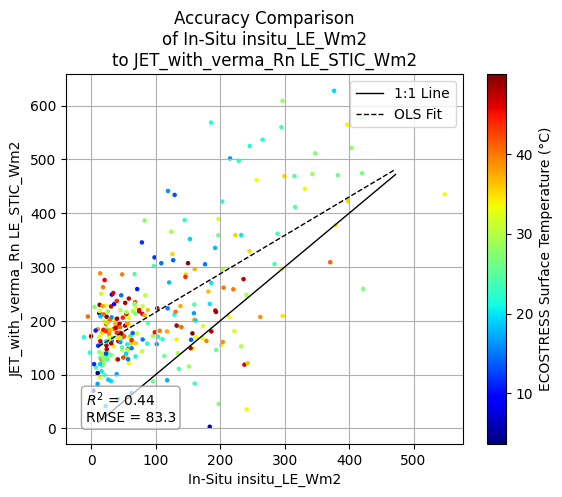

analyzing JET_with_verma_Rn accuracy for LE_PTJPLSM_Wm2 compared to insitu_LE_Wm2


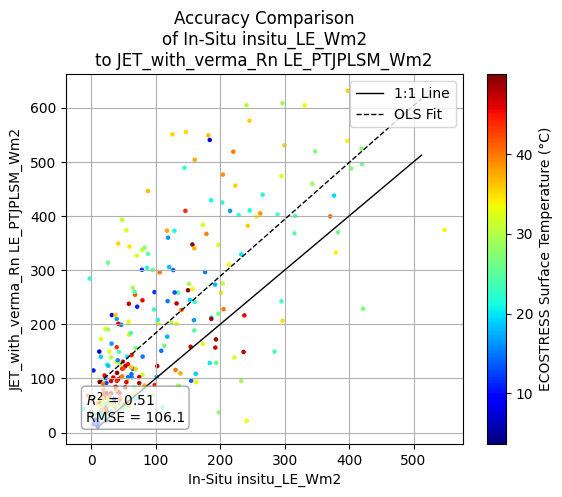

analyzing JET_with_verma_Rn accuracy for LE_PMJPL_Wm2 compared to insitu_LE_Wm2


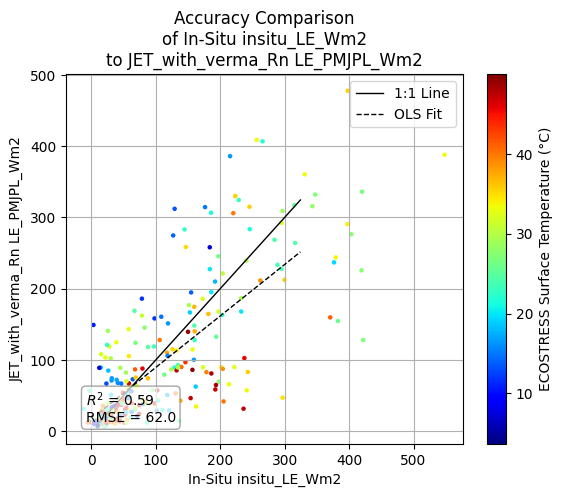

analyzing JET_with_verma_Rn accuracy for LE_Wm2 compared to insitu_LE_Wm2


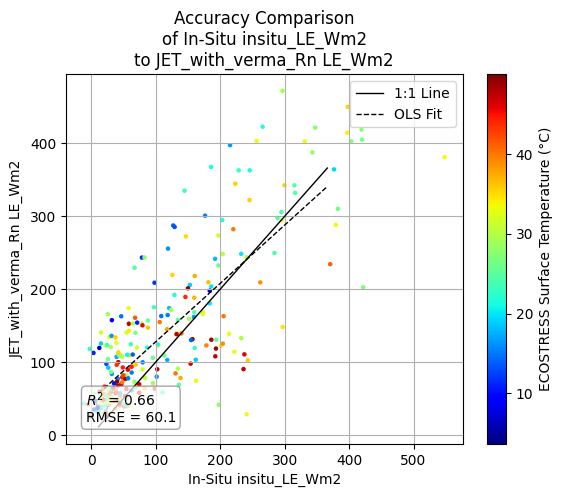

In [7]:
model_name = "JET_with_verma_Rn"
processed = JET_with_verma_Rn(input_df)
insitu_variable = "insitu_LE_Wm2"

output_variables = [
    "LE_BESS_Wm2",
    "LE_STIC_Wm2",
    "LE_PTJPLSM_Wm2",
    "LE_PMJPL_Wm2",
    "LE_Wm2"
]

for output_variable in output_variables:
    try:
        print(f"analyzing {model_name} accuracy for {output_variable} compared to {insitu_variable}")
        
        x_variable = insitu_variable
        y_variable = output_variable

        # Filter out rows with NaN values in either variable
        valid_data = processed[[x_variable, y_variable, 'ST_C']].dropna()
        
        sc = plt.scatter(
            x=valid_data[x_variable],
            y=valid_data[y_variable],
            c=valid_data.ST_C,
            cmap="jet",
            color=None,
            s=5
        )

        # Calculate 5% and 95% tails for x and y variables
        x_5th, x_95th = np.percentile(valid_data[x_variable], [5, 95])
        y_5th, y_95th = np.percentile(valid_data[y_variable], [5, 95])

        min_val = min(x_5th, y_5th)
        max_val = max(x_95th, y_95th)

        # Add 1-to-1 line
        # min_val = min(valid_data[x_variable].min(), valid_data[y_variable].min())
        # max_val = max(valid_data[x_variable].max(), valid_data[y_variable].max())
        plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='-', linewidth=1, label='1:1 Line')

        # Add OLS regression line
        coefs = np.polyfit(valid_data[x_variable], valid_data[y_variable], 1)
        ols_x = np.array([min_val, max_val])
        ols_y = coefs[0] * ols_x + coefs[1]
        plt.plot(ols_x, ols_y, color='black', linestyle='--', linewidth=1, label='OLS Fit')

        # Calculate R-squared and RMSE
        from sklearn.metrics import r2_score, mean_squared_error
        y_true = valid_data[y_variable]
        y_pred = coefs[0] * valid_data[x_variable] + coefs[1]
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        # Annotate R-squared and RMSE on plot in lower left corner
        plt.annotate(f"$R^2$ = {r2:.2f}\nRMSE = {rmse:.1f}",
                    xy=(0.05, 0.05), xycoords='axes fraction',
                    ha='left', va='bottom',
                    fontsize=10,
                    bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.7))

        # Set ticks every 100 for both axes
        # xticks = np.arange(100 * (min_val // 100), 100 * (max_val // 100 + 2), 100)
        # yticks = np.arange(100 * (min_val // 100), 100 * (max_val // 100 + 2), 100)
        # plt.xticks(xticks)
        # plt.yticks(yticks)

        plt.grid(True, zorder=0) 
        plt.xlabel(f"In-Situ {insitu_variable}")
        plt.ylabel(f"{model_name} {output_variable}")
        plt.title(f"Accuracy Comparison\nof In-Situ {insitu_variable}\nto {model_name} {output_variable}")
        plt.colorbar(sc, label="ECOSTRESS Surface Temperature (°C)")
        plt.legend(loc='upper right')
        
        plt.show()
    except Exception as e:
        print(f"Error processing {output_variable}: {e}")
        continue


[2026-01-30 09:55:00 INFO] starting JET table processing
[2026-01-30 09:55:00 INFO] started extracting geometry from JET input table
[2026-01-30 09:55:00 INFO] completed extracting geometry from JET input table (0.003 seconds)
[2026-01-30 09:55:00 INFO] started extracting time from JET input table
[2026-01-30 09:55:00 INFO] completed extracting time from JET input table (0.001 seconds)
[2026-01-30 09:55:00 INFO] running Forest Light Environmental Simulator
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[2026-01-30 09:55:00 INFO] completed processing FLiES-ANN in 0.13 seconds
[2026-01-30 09:55:00 INFO] variable PAR_albedo min: 0.007 mean: 0.055 max: 0.193 nan: 0.00% (nan)
[2026-01-30 09:55:00 INFO] variable NIR_albedo min: 0.066 mean: 0.162 max: 0.530 nan: 0.00% (nan)
[2026-01-30 09:55:00 INFO] variable PAR_direct_Wm2 min: 7.148 mean: 269.735 max: 442.463 nan: 0.00% (nan)
[2026-01-30 09:55:00 INFO] variable SWin_FLiES_ANN min: 163.676 mean: 716.916 max: 1095.605 nan: 0.00% (nan)
[2026-01-30 09:5

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')


[2026-01-30 09:55:00 INFO] completed daylight ET upscaling (elapsed: 0.02 seconds)
[2026-01-30 09:55:00 INFO] completed processing BESS-JPL in 0.08 seconds
[2026-01-30 09:55:00 INFO] variable Rn_BESS_Wm2 min: 67.033 mean: 426.438 max: 815.548 nan: 0.00% (nan)
[2026-01-30 09:55:00 INFO] variable Rn_BESS_Wm2 min: 67.033 mean: 426.438 max: 815.548 nan: 0.00% (nan)
[2026-01-30 09:55:00 INFO] variable LE_BESS_Wm2 min: 3.648 mean: 86.108 max: 368.953 nan: 0.00% (nan)
[2026-01-30 09:55:00 INFO] calculating solar day of year
[2026-01-30 09:55:00 INFO] calculating solar hour of day
[2026-01-30 09:55:00 INFO] calculating daylight hours and sunrise hour
[2026-01-30 09:55:00 INFO] variable LE_BESS_Wm2 min: 3.648 mean: 86.108 max: 368.953 nan: 0.00% (nan)
[2026-01-30 09:55:00 INFO] variable GPP_inst_umol_m2_s min: 0.006 mean: 6.632 max: 39.888 nan: 0.00% (nan)
[2026-01-30 09:55:00 INFO] starting Verma net radiation processing
[2026-01-30 09:55:00 INFO] variable SWout_Wm2 min: 9.139 mean: 79.449 max

/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones available for np.datetime64
  return np.array(arr, dtype='datetime64[ns]')
/opt/homebrew/Caskroom/miniforge/base/envs/ECOv003-L3T-L4T-JET/lib/python3.12/site-packages/solar_apparent_time/solar_apparent_time.py:37: UserWarning: no explicit representation of timezones availab

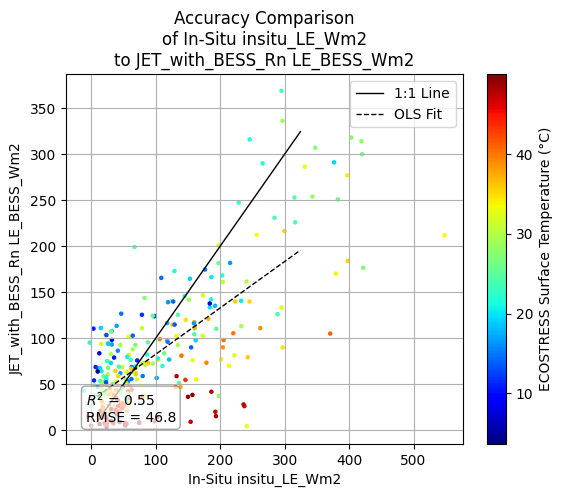

analyzing JET_with_BESS_Rn accuracy for LE_STIC_Wm2 compared to insitu_LE_Wm2


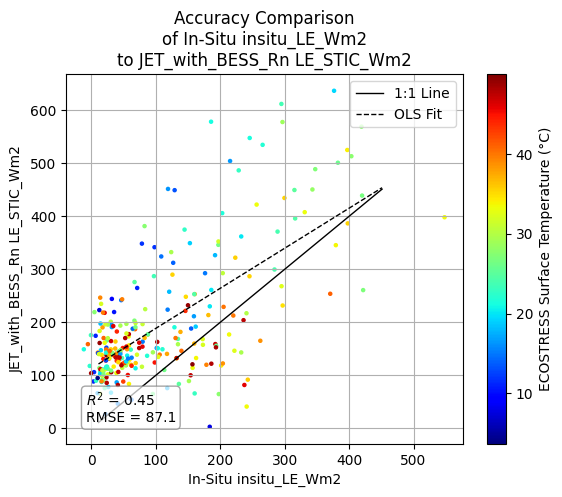

analyzing JET_with_BESS_Rn accuracy for LE_PTJPLSM_Wm2 compared to insitu_LE_Wm2


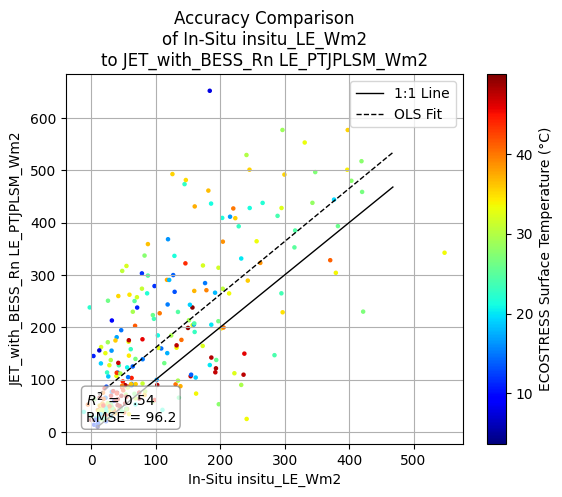

analyzing JET_with_BESS_Rn accuracy for LE_PMJPL_Wm2 compared to insitu_LE_Wm2


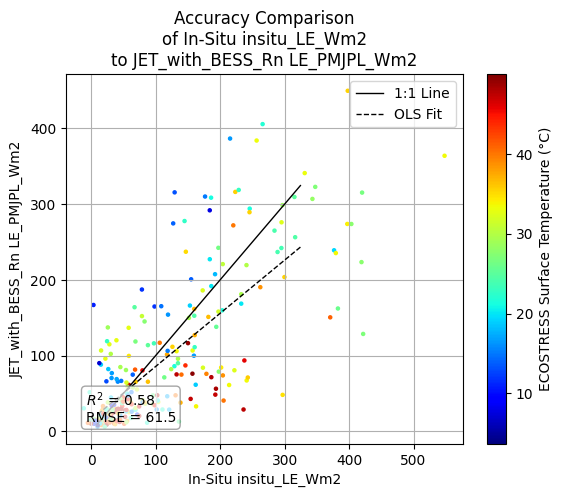

analyzing JET_with_BESS_Rn accuracy for LE_Wm2 compared to insitu_LE_Wm2


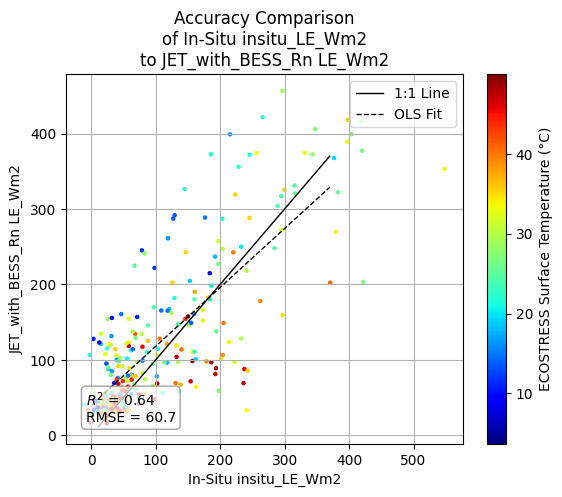

In [8]:
model_name = "JET_with_BESS_Rn"
processed = JET_with_BESS_Rn(input_df)
insitu_variable = "insitu_LE_Wm2"

output_variables = [
    "LE_BESS_Wm2",
    "LE_STIC_Wm2",
    "LE_PTJPLSM_Wm2",
    "LE_PMJPL_Wm2",
    "LE_Wm2"
]

for output_variable in output_variables:
    try:
        print(f"analyzing {model_name} accuracy for {output_variable} compared to {insitu_variable}")
        
        x_variable = insitu_variable
        y_variable = output_variable

        # Filter out rows with NaN values in either variable
        valid_data = processed[[x_variable, y_variable, 'ST_C']].dropna()
        
        sc = plt.scatter(
            x=valid_data[x_variable],
            y=valid_data[y_variable],
            c=valid_data.ST_C,
            cmap="jet",
            color=None,
            s=5
        )

        # Calculate 5% and 95% tails for x and y variables
        x_5th, x_95th = np.percentile(valid_data[x_variable], [5, 95])
        y_5th, y_95th = np.percentile(valid_data[y_variable], [5, 95])

        min_val = min(x_5th, y_5th)
        max_val = max(x_95th, y_95th)

        # Add 1-to-1 line
        # min_val = min(valid_data[x_variable].min(), valid_data[y_variable].min())
        # max_val = max(valid_data[x_variable].max(), valid_data[y_variable].max())
        plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='-', linewidth=1, label='1:1 Line')

        # Add OLS regression line
        coefs = np.polyfit(valid_data[x_variable], valid_data[y_variable], 1)
        ols_x = np.array([min_val, max_val])
        ols_y = coefs[0] * ols_x + coefs[1]
        plt.plot(ols_x, ols_y, color='black', linestyle='--', linewidth=1, label='OLS Fit')

        # Calculate R-squared and RMSE
        from sklearn.metrics import r2_score, mean_squared_error
        y_true = valid_data[y_variable]
        y_pred = coefs[0] * valid_data[x_variable] + coefs[1]
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        # Annotate R-squared and RMSE on plot in lower left corner
        plt.annotate(f"$R^2$ = {r2:.2f}\nRMSE = {rmse:.1f}",
                    xy=(0.05, 0.05), xycoords='axes fraction',
                    ha='left', va='bottom',
                    fontsize=10,
                    bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.7))

        # Set ticks every 100 for both axes
        # xticks = np.arange(100 * (min_val // 100), 100 * (max_val // 100 + 2), 100)
        # yticks = np.arange(100 * (min_val // 100), 100 * (max_val // 100 + 2), 100)
        # plt.xticks(xticks)
        # plt.yticks(yticks)

        plt.grid(True, zorder=0) 
        plt.xlabel(f"In-Situ {insitu_variable}")
        plt.ylabel(f"{model_name} {output_variable}")
        plt.title(f"Accuracy Comparison\nof In-Situ {insitu_variable}\nto {model_name} {output_variable}")
        plt.colorbar(sc, label="ECOSTRESS Surface Temperature (°C)")
        plt.legend(loc='upper right')
        
        plt.show()
    except Exception as e:
        print(f"Error processing {output_variable}: {e}")
        continue
